### Formatting, plotting, and mean absolute error calculation of PBGS (Poisson Beta Gibbs Sampling) data output from Kim and Marioni's Gibbs sampler implemented in MATLAB

* This notebook contains three sections:
    1. Loading and plotting of PBGS parameters
    2. Loading of raw mRNA data preparing to calculate mean absolute error
    3. Calculation of mean absolute error between predicted Poisson-beta distribution and real data

To note, raw PBGS data files are not stored in this repo due to size, please access at https://www.dropbox.com/home/scRNAseq%20files/pbgs_vdh_all_gene_parameters. As they are smaller mean absolute error values are stored in the data folder of the repo

In [1]:
import poisbeta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from poisbeta import fit_poisson_beta_moment

---
##### Loading and plotting of PBGS parameters:

In [2]:
gene_df = pd.read_csv(r'C:\Users\mvc28\OneDrive - University of Bath\data\kings_fshd\fshd_myocyte_rna_seq\gene_info_vdh.csv')
gene_df.rename(index = gene_df['ensembl_gene_id'], inplace=True)
gene_df.drop(["Unnamed: 0", "ensembl_gene_id"], axis=1, inplace=True)

In [3]:
genes = ["PRAMEF12", "PRAMEF1", "PRAMEF2", "TRIM43", "DUX4", "RFPL4B", "ZSCAN4", "RFPL1", "RFPL2"]
interest_df = gene_df[gene_df['hgnc_symbol'].isin(genes)]

In [4]:
interest_df

,entrezgene_id,hgnc_symbol,transcript_length
ENSG00000116726,390999.0,PRAMEF12,1786
ENSG00000116721,65121.0,PRAMEF1,2160
ENSG00000120952,65122.0,PRAMEF2,1642
ENSG00000144015,653192.0,TRIM43,1682
ENSG00000260596,100653046.0,DUX4,768
ENSG00000251258,442247.0,RFPL4B,1900
ENSG00000180532,201516.0,ZSCAN4,2246
ENSG00000128250,5988.0,RFPL1,1496
ENSG00000128253,10739.0,RFPL2,2407


In [5]:
def output_patient_dux4_targets(df_loc, patient, interest_df):
    df = pd.read_csv(f"{df_loc}\patient_{patient}_result_10000.txt", sep="\t")

    interest_df_params = df[df["Gene"].isin(interest_df.index.values)].copy()
    interest_df_params.drop(columns=[x for x in interest_df_params.columns[4:]], inplace=True)

    interest_df_params.insert(4, "on off ratio", interest_df_params['Koni'] / interest_df_params['Koffi'])
    interest_df_params.columns = ["Gene" , "v_0", "k_0", "k_1", "k_0/k_1"]

    interest_df_params["Gene"] = interest_df["hgnc_symbol"].values

    return interest_df_params

In [6]:
patients = ["A", "B", "E", "F"]

patient_dfs = [output_patient_dux4_targets("C:\\Users\\mvc28\\OneDrive - University of Bath\\data\\kings_fshd\\pbgs\\by_patient\\dux4_results\\",
                                f"{patient}", interest_df) for patient in patients]

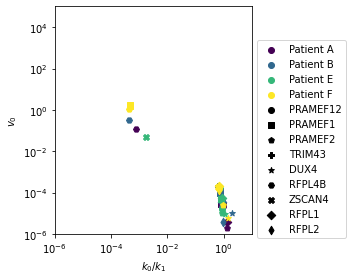

In [7]:
scale = 4
fig, ax = plt.subplots(figsize=(scale*1.25, scale))

cmap = plt.colormaps['viridis']
c_list = cmap(np.linspace(0, 1, len(patient_dfs)))

markers = ["o", "s", "p", "P", "*", "H", "X", "D", "d"]

for index1, patient in enumerate(patients):
    for index2, gene in enumerate(genes):
        ax.scatter(patient_dfs[index1]["k_0/k_1"].to_numpy()[index2],
                    patient_dfs[index1]["v_0"].to_numpy()[index2],
                    color=c_list[index1], marker=markers[index2])

for index1, patient in enumerate(patients):
    ax.scatter(0, 0, color=c_list[index1], label=f"Patient {patient}")

for index2, gene in enumerate(genes):
    ax.scatter(0, 0, color="k", marker=markers[index2], label=gene)

ax.legend(bbox_to_anchor=(1, -0.04, 1, 0), loc="lower left")
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel("$v_0$")
ax.set_xlabel("$k_0/k_1$")

ax.set_ylim(1e-6, 1e5)
ax.set_xlim(1e-6, 1e1)

fig.tight_layout()
# fig.savefig("km_dux4_targets_all_patients.png", dpi=300)

---
##### 2. Loading of raw mRNA data preparing to calculate mean absolute error:

In [8]:
mRNA_df = pd.read_csv(r'C:\Users\mvc28\OneDrive - University of Bath\data\kings_fshd\fshd_myocyte_rna_seq\mRNA_data_vdh.csv')

In [9]:
mRNA_df.rename(index = mRNA_df['Unnamed: 0'], inplace=True)
mRNA_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [10]:
mRNA_df.columns = [f"{cell_n}" for cell_n in range(len(mRNA_df.T))]

In [11]:
gene_df = pd.read_csv(r'C:\Users\mvc28\OneDrive - University of Bath\data\kings_fshd\fshd_myocyte_rna_seq\gene_info_vdh.csv')
gene_df.rename(index = gene_df['ensembl_gene_id'], inplace=True)
gene_df.drop(["Unnamed: 0", "ensembl_gene_id"], axis=1, inplace=True)

In [12]:
cond_df = pd.read_csv(r'C:\Users\mvc28\OneDrive - University of Bath\data\kings_fshd\fshd_myocyte_rna_seq\condition_info_vdh.csv')
cond_df.rename(index = {0:"Disease", 1: "Patient"}, inplace=True)
cond_df.drop("Unnamed: 0", axis=1, inplace=True)
cond_df.columns = [f"{cell_n}" for cell_n in range(len(cond_df.T))]


In [13]:
# Combine dataframes
df = pd.concat([mRNA_df, cond_df])
df = pd.concat([df, gene_df], axis=1)

In [14]:
# Delete old from memory
del(mRNA_df)
del(gene_df)
del(cond_df)

In [15]:
df

,0,1,2,3,4,5,6,7,8,9,...,7040,7041,7042,7043,7044,7045,7046,entrezgene_id,hgnc_symbol,transcript_length
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,100422919.0,MIR1302-11,712.0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,654835.0,FAM138A,1187.0
ENSG00000186092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,79501.0,OR4F5,918.0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,2748.0
ENSG00000239945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,1319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198727,31,2,38,12,85,48,1,58,31,2,...,4,20,0,6,21,13,32,4519.0,MT-CYB,1141.0
ENSG00000271254,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,101928050.0,NaN,4088.0
ENSG00000268674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,100133301.0,FAM231B,510.0
Disease,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,...,Ctrl,Ctrl,Ctrl,Ctrl,Ctrl,Ctrl,Ctrl,NaN,NaN,NaN


---
##### 3. Calculation of mean absolute error between predicted Poisson-beta distribution and real data:

In [15]:
def create_patient_pb_dux4_plus_targets_input(df, patient, genes):
    gene_index = df[df["hgnc_symbol"].isin(genes)].index.values
    patient_cols = [col for col in df.columns if df[col]["Patient"] == patient]

    n_df = df[patient_cols].copy()
    n_df.columns = [f"Cell{cell_n + 1}" for cell_n in range(n_df.shape[1])]

    n_df = n_df.filter(axis=0, items=gene_index)
    data = [x for x in n_df[n_df.columns].to_numpy(dtype='int32')]
    
    return data

In [16]:
patients = ["A", "B", "E", "F"]
genes = ["PRAMEF12", "PRAMEF1", "PRAMEF2", "TRIM43", "DUX4", "RFPL4B", "ZSCAN4", "RFPL1", "RFPL2"]

In [17]:
def target_genes_mae_plot(df, patients, genes, thetas):

    scale = 4
    fig, ax = plt.subplots(figsize=(scale, scale))

    cmap = plt.colormaps['viridis']
    c_list = cmap(np.linspace(0, 1, len(patients)))

    cumsum_mae = 0

    for index1, patient in enumerate(patients):
        patient_data = create_patient_pb_dux4_plus_targets_input(df, patient=patient, genes=genes)

        for index2, gene in enumerate(genes):
            gene_data = patient_data[index2]

            if gene_data.max() != 0:
                theta = np.log(thetas[index1].iloc[index2].to_numpy()[1:-1].astype("float64"))

                grid = np.arange(gene_data.max() + 1)
                p = gene_data.shape[0] * np.array([poisbeta.mle.poisson_beta_pmf(theta=theta,
                                        x=i, s=1) for i in grid]).ravel()
                
                gene_hist = np.histogram(gene_data, np.append(grid, grid[-1] + 1))

                mae = np.mean(np.abs(gene_hist[0] - p))
                cumsum_mae = cumsum_mae + mae

                ax.scatter(genes[index2], mae, color=c_list[index1])

    for index1, patient in enumerate(patients):
            ax.scatter(0, 0, color=c_list[index1], label=f"Patient {patient}")

    ax.tick_params(axis='x', labelrotation = 45)
    ax.legend()
    ax.set_yscale("log")
    ax.set_ylim(2e-3, 8e0)
    ax.set_ylabel("Mean absolute error")

    print(cumsum_mae)

    fig.tight_layout()
    fig.savefig("mae_km.png", dpi=300)

C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(px) - sp.betaln(kon, koff) - (kon + koff - 1) * np.log(2)
C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(px) - sp.betaln(kon, koff) - (kon + koff - 1) * np.log(2)
C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(px) - sp.betaln(kon, koff) - (kon + koff - 1) * np.log(2)
C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:17: 

30.887250941767224


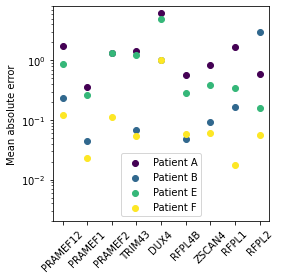

In [18]:
target_genes_mae_plot(df, patients, genes, patient_dfs)

In [23]:
def mae_csv(df, patients, genes, thetas):

    mae_array = np.zeros((len(patients), len(genes)))

    for index1, patient in enumerate(patients):
        patient_data = create_patient_pb_dux4_plus_targets_input(df, patient=patient, genes=genes)

        for index2, gene in enumerate(genes):
            gene_data = patient_data[index2]

            if gene_data.max() != 0:
                theta = np.log(thetas[index1].iloc[index2].to_numpy()[1:-1].astype("float64"))

                grid = np.arange(gene_data.max() + 1)
                p = gene_data.shape[0] * np.array([poisbeta.mle.poisson_beta_pmf(theta=theta,
                                        x=i, s=1) for i in grid]).ravel()
                
                gene_hist = np.histogram(gene_data, np.append(grid, grid[-1] + 1))

                mae = np.mean(np.abs(gene_hist[0] - p))
                mae_array[index1, index2] = mae

    np.savetxt("pbgs_mae.csv", mae_array, delimiter=",")

In [24]:
mae_csv(df, patients, genes, patient_dfs)

C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(px) - sp.betaln(kon, koff) - (kon + koff - 1) * np.log(2)
C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(px) - sp.betaln(kon, koff) - (kon + koff - 1) * np.log(2)
C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(px) - sp.betaln(kon, koff) - (kon + koff - 1) * np.log(2)
C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:17: 